In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import PIL.Image as Image
import numpy as np
import random
import shutil
import os

In [3]:
data_dir = "./data/autoencoder_db/"


loader = transforms.Compose([transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + 'train', transform=loader)
valid_data = datasets.ImageFolder(data_dir + 'valid', transform=loader)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

unloader = transforms.ToPILImage()

In [4]:
def save_im(tensor, title):
    image = tensor.cpu().clone()
    x = image.clamp(0, 255)
    x = x.view(x.size(0), 3, 96, 96)
    save_image(x, "./generated_data/image_{}.png".format(title))


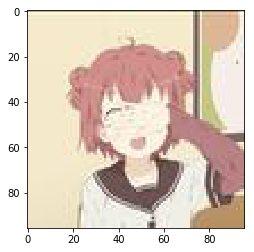

In [5]:
# img_path = random.choice(os.listdir(data_dir + 'train/anime/'))
# pil_img = Image.open(data_dir + 'train/anime/' + img_path)
img = unloader(iter(trainloader).next()[0][0])
_ = plt.imshow(img)

In [6]:
img1, _ = iter(trainloader).next()
img1.view(img1.size(0), 3*96*96).shape

torch.Size([64, 27648])

In [7]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=3, padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 5, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
def validation(model, testloader, criterion, criterion2=None, mode=1):
    test_loss = 0
    for data in testloader:
        images, _ = data
        images = images.to('cuda')
        output = model.forward(images)
        if mode == 2:
            output = torch.sigmoid(output.view(output.size(0), 3*96*96))
            images = torch.sigmoid(images.view(images.size(0), 3*96*96))
            test_loss += criterion(output, images).item()
        
        elif mode == 3:
            loss1 = criterion(output, images).item()
            
            output = torch.sigmoid(output.view(output.size(0), 3*96*96))
            images = torch.sigmoid(images.view(images.size(0), 3*96*96))
            
            loss2 = 0.1 * criterion2(output, images).item()
            test_loss += loss1 + loss2
        else:
            test_loss += criterion(output, images).item()
    return test_loss

In [12]:
model = autoencoder().to('cuda')
criterion = nn.MSELoss()
criterion2 =nn.BCELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-4)

num_epochs = 150

running_loss = 0
steps = 0
print_every = 35
for epoch in range(num_epochs):
    model.train()
    for data in trainloader:
        steps += 1
        img, _ = data
        img = img.to('cuda')
        output = model(img)
        loss1 = criterion(output, img)
        
        img = torch.sigmoid(img.view(img.size(0), 3*96*96))
        output = torch.sigmoid(output.view(output.size(0), 3*96*96))
        loss2 = 0.1*criterion2(output, img)
        
        loss = loss1 + loss2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss = validation(model, validloader, criterion, criterion2, mode=3)
            
            model.train()
            
            print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
                  "Training Loss: {:.4f}.. ".format(running_loss/print_every),
                  "valid Loss: {:.4f}.. ".format(valid_loss/len(validloader)))
            running_loss = 0
    if epoch % 10 == 0:
        save_im(output, 'epoch '+str(epoch))

Epoch: 1/150..  Training Loss: 0.4933..  valid Loss: 0.9247.. 
Epoch: 1/150..  Training Loss: 0.2317..  valid Loss: 0.7528.. 
Epoch: 2/150..  Training Loss: 0.1574..  valid Loss: 0.7261.. 
Epoch: 2/150..  Training Loss: 0.1436..  valid Loss: 0.7152.. 
Epoch: 2/150..  Training Loss: 0.1355..  valid Loss: 0.7065.. 
Epoch: 3/150..  Training Loss: 0.1274..  valid Loss: 0.6973.. 
Epoch: 3/150..  Training Loss: 0.1186..  valid Loss: 0.6890.. 
Epoch: 4/150..  Training Loss: 0.1119..  valid Loss: 0.6836.. 
Epoch: 4/150..  Training Loss: 0.1072..  valid Loss: 0.6791.. 
Epoch: 4/150..  Training Loss: 0.1044..  valid Loss: 0.6763.. 
Epoch: 5/150..  Training Loss: 0.1018..  valid Loss: 0.6731.. 
Epoch: 5/150..  Training Loss: 0.0997..  valid Loss: 0.6714.. 
Epoch: 6/150..  Training Loss: 0.0982..  valid Loss: 0.6703.. 
Epoch: 6/150..  Training Loss: 0.0981..  valid Loss: 0.6696.. 
Epoch: 6/150..  Training Loss: 0.0973..  valid Loss: 0.6696.. 
Epoch: 7/150..  Training Loss: 0.0968..  valid Loss: 0.

In [30]:
truth.type(torch.cuda.LongTensor)

tensor([[ 0,  0,  0,  ...,  1,  1,  1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [ 1,  1,  1,  ...,  1,  1,  1],
        ...,
        [ 1,  1,  1,  ...,  1,  1,  1],
        [ 1,  1,  0,  ...,  1,  1,  1],
        [-2, -2, -2,  ..., -1, -1, -1]], device='cuda:0')

In [31]:
truth

tensor([[ 0.2157,  0.1855,  0.1704,  ...,  1.3333,  1.3333,  1.3333],
        [-1.7753, -1.7602, -1.7451,  ..., -1.4408, -1.8475, -1.6296],
        [ 1.0000,  1.0000,  1.0000,  ...,  1.3043,  1.3333,  1.3333],
        ...,
        [ 1.0000,  1.0000,  1.0000,  ...,  1.3333,  1.3333,  1.3333],
        [ 1.0000,  1.0000,  0.9095,  ...,  1.3333,  1.3333,  1.3333],
        [-2.0015, -2.0015, -2.0015,  ..., -1.6296, -1.7749, -1.8765]],
       device='cuda:0')

In [12]:
folder_list = ['blonde_hair','blue_eyes','bow']
for folder in folder_list:
    full_path = './data/anime-faces/' + folder
    for img in os.listdir(full_path):
        shutil.copy(full_path + '/' + img, './data/autoencoder_db/all_data/anime/')

In [2]:

def split_folder(path_to_data, path_to_create_split, split_ratio=0.1):    
    data_size = len(os.listdir(path_to_data))
    
    split_size = math.floor(data_size*0.1)
    train_size = data_size - split_size*2
    
    for sizes, folder in zip([train_size, split_size, split_size], ['train', 'test', 'valid']):
        count = 0
        while count < sizes:
            img = random.choice(os.listdir(path_to_data))
            os.rename(path_to_data + img, path_to_create_split + folder +'/anime/' + img)
            count += 1

In [3]:
import math
math.floor(493*0.1)

49

In [4]:
path_to_data = './data/autoencoder_db/all_data/anime/'
path_to_create_split = './data/autoencoder_db/'
split_folder(path_to_data, path_to_create_split)

In [25]:
os.path.isdir(path_to_create_split + 'train/anime')

True